In [269]:
import torch
import torch.nn as nn
from torch_geometric.datasets import QM7b, Planetoid, TUDataset
from torch_geometric.utils import to_networkx
import networkx as nx
import numpy as np
import torch.optim as optim
from sklearn.model_selection import train_test_split
import random
from torch_geometric.nn import GAT, GATConv
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.optim.lr_scheduler as lr_scheduler
import torch_geometric.nn as tgnn
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax
import binary_class
import sys
sys.path.append('..')
import functions.edge_index_functions as eif
import functions.overall_functions as overall_functions

In [270]:
overall_functions.set_all_seeds(42)

In [271]:
dataset = TUDataset('proteins', 'PROTEINS')
dataset.transform = T.NormalizeFeatures()
dataset

c:\Users\szige\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) 

PROTEINS(1113)

In [272]:
diameters = overall_functions.get_diameters(dataset)

In [273]:
torch.max(diameters)

tensor(64.)

In [274]:
X = [x.x for x in dataset]
y = torch.cat([x.y for x in dataset]).to(torch.float)
edge_indices =[x.edge_index for x in dataset]

In [275]:
class GNN(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super(GNN, self).__init__()
        self.pre_mlp = nn.Linear(in_features, 8)
        self.layernorm1 = nn.LayerNorm(8)
        self.layer1 = eif.GraphAttentionLayer(8, 16, 5, 0.3, 0.2)
        self.layernorm2 = nn.LayerNorm(16)
        self.layer2 = eif.GraphAttentionLayer(16, 16, 5, 0.3, 0.2)
        self.layernorm3 = nn.LayerNorm(16)
        self.layer3 = eif.GraphAttentionLayer(16, 32, 5, 0.3, 0.2)
        self.layernorm4 = nn.LayerNorm(32)
        self.layer4 = eif.GraphAttentionLayer(32, 64, 5, 0.3, 0.2)
        self.layernorm5 = nn.LayerNorm(64)
        self.linear = nn.Linear(64, out_features)
        self.skip_connection = nn.Linear(8, 16)
        self.skip_connection2 = nn.Linear(16, 32)
        self.skip_connection3 = nn.Linear(32, 64)

        
    def forward(self, features: torch.Tensor, edge_index: torch.Tensor, indices:torch.Tensor):
        features = self.pre_mlp(features)
        features = self.layernorm1(features)
        features = torch.relu(features)

        features_skip = self.skip_connection(features)
        features = self.layer1(features, edge_index)
        features = self.layernorm2(features)
        features = torch.relu(features)

        features_skip = features
        features = self.layer2(features, edge_index)
        features = self.layernorm3(features)
        features = torch.relu(features + features_skip)

        features_skip = self.skip_connection2(features)
        features = self.layer3(features, edge_index)
        features = self.layernorm4(features)
        features = torch.relu(features + features_skip)

        features_skip = self.skip_connection3(features)
        features = self.layer4(features, edge_index)
        features = self.layernorm5(features)
        features = torch.relu(features + features_skip)

        readout = self.pooling(features, indices)
        readout = self.linear(readout)
        return readout        

    def pooling(self, features: torch.Tensor, indices: torch.Tensor):
        graph_embedding = torch.zeros(indices.max().item() + 1, features.size(1))
        graph_embedding = graph_embedding.index_add(0, indices, features)
        count = torch.bincount(indices)
        graph_embedding = graph_embedding / count.unsqueeze(1)
        return graph_embedding

In [276]:
train_indices, val_indices, test_indices = overall_functions.get_indices(len(dataset), 0.8, 0.1)
len(train_indices), len(val_indices), len(test_indices)

(890, 111, 112)

In [277]:
batch_size = 32
X_train, y_train, edge_train, indices_train = eif.get_batched_data([X[i] for i in train_indices], y[train_indices], [edge_indices[i] for i in train_indices], batch_size)
X_val, y_val, edge_val, indices_val = eif.get_batched_data([X[i] for i in val_indices], y[val_indices], [edge_indices[i] for i in val_indices], batch_size)
X_test, y_test, edge_test, indices_test = eif.get_batched_data([X[i] for i in test_indices], y[test_indices], [edge_indices[i] for i in test_indices], batch_size)

len(X_train), len(y_train), len(edge_train), len(indices_train), len(X_val), len(y_val), len(edge_val), len(indices_val), len(X_test), len(y_test), len(edge_test), len(indices_test)

(28, 28, 28, 28, 4, 4, 4, 4, 4, 4, 4, 4)

In [278]:
def accuracy_fn(logits: torch.Tensor, labels:torch.Tensor):
    logits = torch.round(torch.sigmoid(logits))
    return torch.sum(logits == labels) / logits.shape[0]

In [279]:
in_features = X[0].shape[-1]
out_features = 1
model = GNN(in_features, out_features)

In [280]:
num_epochs = 100
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss()
best_state_dict = None
best_loss = np.inf
patience = 10
patience_counter = 0


binary_class.fit(model, num_epochs, patience, optimizer, loss_fn, X_train, edge_train, indices_train, y_train, X_val, edge_val, indices_val, y_val)

Epoch: 1 | Train Loss: 0.6889 | Val Loss: 0.6788 | Val acc: 0.5531
Epoch: 2 | Train Loss: 0.6608 | Val Loss: 0.6635 | Val acc: 0.5932
Epoch: 3 | Train Loss: 0.6457 | Val Loss: 0.6441 | Val acc: 0.6255
Epoch: 4 | Train Loss: 0.629 | Val Loss: 0.623 | Val acc: 0.7146
Epoch: 5 | Train Loss: 0.615 | Val Loss: 0.6045 | Val acc: 0.7146
Epoch: 6 | Train Loss: 0.6062 | Val Loss: 0.5915 | Val acc: 0.6979
Epoch: 7 | Train Loss: 0.6029 | Val Loss: 0.5837 | Val acc: 0.7224
Epoch: 8 | Train Loss: 0.5987 | Val Loss: 0.5786 | Val acc: 0.7146
Epoch: 9 | Train Loss: 0.5962 | Val Loss: 0.5721 | Val acc: 0.7068
Epoch: 10 | Train Loss: 0.5955 | Val Loss: 0.572 | Val acc: 0.7068
Epoch: 11 | Train Loss: 0.5935 | Val Loss: 0.5734 | Val acc: 0.7068
Epoch: 12 | Train Loss: 0.5924 | Val Loss: 0.5719 | Val acc: 0.7146
Epoch: 13 | Train Loss: 0.5895 | Val Loss: 0.5705 | Val acc: 0.7146
Epoch: 14 | Train Loss: 0.5874 | Val Loss: 0.5666 | Val acc: 0.7146
Epoch: 15 | Train Loss: 0.5862 | Val Loss: 0.567 | Val acc: 0

In [281]:
test_logits, test_labels = binary_class.get_test(model, X_test, edge_test, indices_test, y_test)

test_logits.shape, test_labels.shape

(torch.Size([112]), torch.Size([112]))

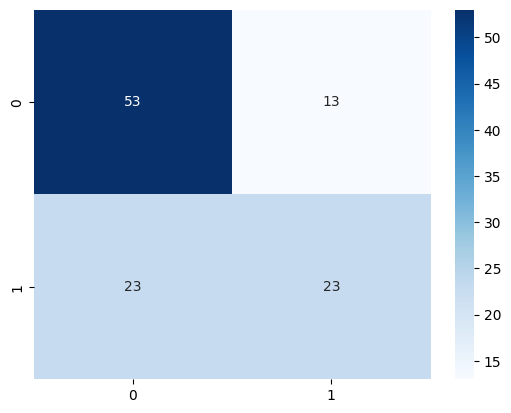

In [282]:
sns.heatmap(confusion_matrix(test_labels, test_logits), annot=True, cmap='Blues')
plt.show()

In [283]:
accuracy_fn(test_logits, test_labels)

tensor(0.6786)